# **Sarcasm Detector** - *Final Deployed Version*

Welcome to the notebook which depicts the training of a sarcasm detection model based on the techniques listed in the popular paper titled **Attention is all you need** (Vaswani et al). [Here](https://arxiv.org/abs/1706.03762) is the link to the original paper. Some insights were also derived from the paper titled **BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding** (Google AI Language). This paper can be found [here](https://arxiv.org/pdf/1810.04805.pdf)

*The model in this final version uses self-attention (Paralleized through Multi-Headed Attention) , subword tokenization , and positional encodings (in combination with word embeddings). These techniques have been used to create an Encoder which consists of 6 encoder layers , each layer consisting of a fully connected feed-forward network of size 512. 8 attention heads have been used. Each section has been comprehensively described in the readme file.*

In the previous notebook we trained three similar models (revolving around the Encoder architecture) using Encoders with a CNN layer and Encoders with a LSTM layer. However on some experimentation I found this version of the model to work best for my task. Even more impressively the model generalizes well and only consumes **28 MB of space**.




In [ ]:
print(tf.__version__)
print(nltk.__version__)


2.5.0
3.2.5


In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import re
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import string
import time


nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df1=pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json",lines=True) #Reading the dataframe
df1=df1[['headline','is_sarcastic']]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      28619 non-null  object
 1   is_sarcastic  28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [ ]:
#Undersampling 10 percent of the sarcastic comments. This improved the f1-score after conducting a few experiments.
df=df1.drop(df1[df1['is_sarcastic']==1].sample(frac=0.10).index) 
df=df.reset_index()

In [ ]:
#Observing the dataframe
df.head()

,index,headline,is_sarcastic
0,0,thirtysomething scientists unveil doomsday clo...,1
1,1,dem rep. totally nails why congress is falling...,0
2,2,eat your veggies: 9 deliciously different recipes,0
3,3,inclement weather prevents liar from getting t...,1
4,4,mother comes pretty close to using word 'strea...,1


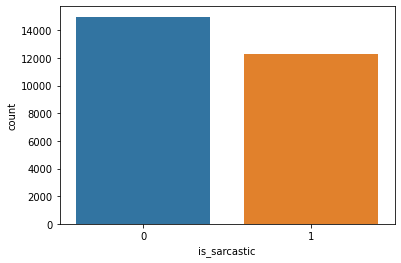

In [ ]:
#Visualising the target variable after undersampling
sns.countplot(data=df,x=df.is_sarcastic);

In [ ]:
#Seeing some sarcastic comments
pd.options.display.max_colwidth = 200
pd.DataFrame(df[df['is_sarcastic']==1]['headline']).head(10)

,headline
0,thirtysomething scientists unveil doomsday clock of hair loss
3,inclement weather prevents liar from getting to work
4,mother comes pretty close to using word 'streaming' correctly
7,richard branson's global-warming donation nearly as much as cost of failed balloon trips
8,shadow government getting too large to meet in marriott conference room b
14,ford develops new suv that runs purely on gasoline
16,area boy enters jumping-and-touching-tops-of-doorways phase
17,area man does most of his traveling by gurney
21,guard in video game under strict orders to repeatedly pace same stretch of hallway
25,secret service agent not so secret about being david alan grier fan


In [ ]:
#Utility functions to help preprocess text and map conntractions
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s$", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
stopwords_english = set(stopwords.words('english'))-set(['No','no','not','Not'])
def preprocess(text,stopwords=stopwords_english):
    lemmatizer = WordNetLemmatizer()


    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    #Decontract texts
    text=decontract(text)
    # tokenize texts


    texts_clean = []
    for word in text.split():
        if (word not in stopwords_english and  # remove stopwords
                word not in set(string.punctuation)-set(['!','?','.','@',':'])):  # remove punctuation
            #Lemmatize word 
            lem_word = lemmatizer.lemmatize(word,"v")  # Lemmatizing word
            texts_clean.append(lem_word)

    return " ".join(texts_clean)

In [ ]:
#Transform the inputs and also split the data into training and test sets.
#I have used a split of 80-20 to make sure our model learns better since it is deep.
inputs=list(df['headline'].apply(lambda x: preprocess(x)))
labels=list(df['is_sarcastic'])
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2)


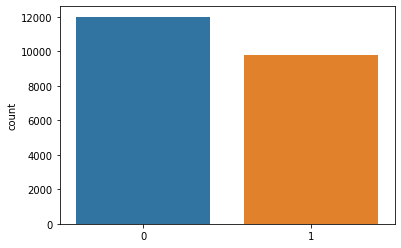

In [ ]:
#Making sure our split is balanced
sns.countplot(x=y_train);

In [ ]:
#Tokenizing using subwords as opposed to characters or entire words. This helps improve performance and was used while training BERT ,
#The maxlen of 50 has been experimentally chosen and is shorter than a few of the longest training inputs. This was done 
# as most inputs are within this length and we can train faster. 
def subword_tokenize(train_corpus, vocab_size=2**14, max_length=50,tokenizer=None):
  # Create the vocabulary using Subword tokenization
  if(tokenizer==None):
    tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(train_corpus, target_vocab_size=2**14)
  else:
    tokenizer_corpus=tokenizer
  # Get the final vocab size
  vocab_size = tokenizer_corpus.vocab_size 
  
  # Tokenize the corpus
  sentences = [tokenizer_corpus.encode(sentence) for sentence in train_corpus]

  #Pad the sentences with 0s upto a length of 50
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,value=0,padding='post',maxlen=50)
  
  return sentences, tokenizer_corpus, vocab_size

In [ ]:
tokenized_inputs,tokenizer,vocab_size=subword_tokenize(train_corpus=X_train)
tokenized_test_inputs,_,vocab_size2=subword_tokenize(X_test,tokenizer=tokenizer)

In [ ]:
# import pickle
# filename = 'tokenizer.sav'
# pickle.dump(tokenizer, open(filename, 'wb'))

In [ ]:
# Define a dataset 
# A batch size of 128 has been chosen for the task
dataset = tf.data.Dataset.from_tensor_slices((tokenized_inputs, y_train))
dataset = dataset.shuffle(len(tokenized_inputs), reshuffle_each_iteration=True).batch(128, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Implemented based on the Attention is all you need paper.
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculating  QK.T
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Scale the dot product for improved training speed and stability 
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply the mask
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product of QK.T with Values 
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

In [ ]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_weights = layers.Dense(units=self.d_model)
        self.key_weights = layers.Dense(units=self.d_model)
        self.value_weights = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_weights = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, n_heads, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_weights(queries)
        keys = self.key_weights(keys)
        values = self.value_weights(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_weights(concat_attention)
        
        return outputs

In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
        self.final_layer = layers.Dense(units=2, name="final_layer")
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)
        #print(outputs.shape)

        logits=tf.math.reduce_mean(outputs,1)


        logits=self.final_layer(logits)

        return logits 

In [ ]:
def create_padding_mask(seq): #seq: (batch_size, seq_length)
# Create the mask for padding
  mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
import pickle
tokenizer=pickle.load(open('/content/tokenizer.sav', 'rb'))

In [ ]:
loaded_model = pickle.load(open('/content/finalized_model (1).sav', 'rb'))

In [ ]:
example="Today is such a beautiful day , the weather is perfect to sit inside ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Today is such a beautiful day , the weather is perfect to sit inside .
[1]


In [ ]:
example="Today is such a beautiful day , the weather is perfect for football ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Today is such a beautiful day , the weather is perfect for football .
[0]


In [ ]:
example="Trump's tenure oversaw a massive economic decline , definitely going to vote for him again ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Trump's tenure oversaw a massive economic decline , definitely going to vote for him again .
[1]


In [ ]:
def create_padding_mask(seq): #seq: (batch_size, seq_length)
# Create the mask for padding
  mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

def loss_function(target, pred): #Notice from_logits=True
  return tf.keras.losses.BinaryCrossentropy(from_logits=True)(target,pred)

#Use a custom scheduler as per the paper with 4000 warmup steps

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def main_train(dataset, encoder, n_epochs, print_every=50):
  ''' Train the Encoder model for n epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (inputs, targets)) in enumerate(dataset):

        #Since we are using the binary cross entropy loss
        targets = pd.get_dummies(targets).astype('float').values
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = encoder(inputs, create_padding_mask(inputs), True)
            # Calculate the loss
            loss = loss_function(targets, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, encoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
        # Save and store the metrics
        train_loss(loss)
       
        train_accuracy(targets, predictions)
        
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            


  return losses, accuracies

In [ ]:
ENCODER_LAYERS=6
FFN_UNITS=512
ATTN_HEADS=8
DROPOUT_RATE=0.1
EMBEDDING_DIM=256

In [ ]:
tf.keras.backend.clear_session()
# Create the Encoder model
encoder = Encoder(ENCODER_LAYERS,FFN_UNITS,ATTN_HEADS,DROPOUT_RATE,vocab_size,EMBEDDING_DIM)


# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")
# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(256)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
losses, accuracies = main_train(dataset, encoder, 5). #Training beyond 5 epochs causes overfitting

Starting epoch 1
Epoch 1 Batch 0 Loss 0.9332 Accuracy 0.4180
Epoch 1 Batch 50 Loss 0.7477 Accuracy 0.5058
Epoch 1 Batch 100 Loss 0.7185 Accuracy 0.5117
Epoch 1 Batch 150 Loss 0.7015 Accuracy 0.5238
Starting epoch 2
Epoch 2 Batch 0 Loss 0.6059 Accuracy 0.6367
Epoch 2 Batch 50 Loss 0.6105 Accuracy 0.6477
Epoch 2 Batch 100 Loss 0.5931 Accuracy 0.6643
Epoch 2 Batch 150 Loss 0.5717 Accuracy 0.6828
Starting epoch 3
Epoch 3 Batch 0 Loss 0.4384 Accuracy 0.7734
Epoch 3 Batch 50 Loss 0.4335 Accuracy 0.7903
Epoch 3 Batch 100 Loss 0.4288 Accuracy 0.7919
Epoch 3 Batch 150 Loss 0.4286 Accuracy 0.7926
Starting epoch 4
Epoch 4 Batch 0 Loss 0.3200 Accuracy 0.8672
Epoch 4 Batch 50 Loss 0.3021 Accuracy 0.8681
Epoch 4 Batch 100 Loss 0.3116 Accuracy 0.8627
Epoch 4 Batch 150 Loss 0.3107 Accuracy 0.8624
Starting epoch 5
Epoch 5 Batch 0 Loss 0.2176 Accuracy 0.9102
Epoch 5 Batch 50 Loss 0.2106 Accuracy 0.9112
Epoch 5 Batch 100 Loss 0.2164 Accuracy 0.9077
Epoch 5 Batch 150 Loss 0.2304 Accuracy 0.9018


In [ ]:
def predict(encoder,tokenized_sentences):
  logits=encoder(tokenized_sentences,create_padding_mask(tokenized_sentences),False)
  predictions=np.argmax(tf.keras.layers.Softmax()(logits),axis=1)
  return predictions

In [ ]:
test_accuracy=sum((predict(encoder,tokenized_test_inputs)==y_test))
test_accuracy/=len(y_test)
print(test_accuracy)
from sklearn.metrics import classification_report
print(classification_report(predict(encoder,tokenized_test_inputs),y_test))

0.8231841526045488
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      3150
           1       0.77      0.83      0.80      2302

    accuracy                           0.82      5452
   macro avg       0.82      0.82      0.82      5452
weighted avg       0.83      0.82      0.82      5452



In [ ]:
examples=['Woman wins award for safe driving','I work forty hours a week for me to be this poor.','I would kill for a Nobel Peace Prize.','Depression is merely anger without enthusiasm.','Two wrongs don’t make a right take your parents as an example .','If I wanted to kill myself I’d climb your ego and jump to your IQ.','Always remember that you are absolutely unique just like everyone else .','Congratulations, If you press the elevator button three times it goes into hurry mode – really...','Hello my name is Raj and I study computer science!','Please get me some fruits from the store .','Want to hang out today ?','Presidency is probably the toughest job around','We should go out and play football','Discounted items end up being the most expensive']

In [ ]:
#example='Woman wins award for safe driving'
for example in examples:
  sentence=tokenizer.encode(preprocess(example))
  sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
  print(example)
  print(predict(encoder,sentence))


Woman wins award for safe driving
[0]
I work forty hours a week for me to be this poor.
[1]
I would kill for a Nobel Peace Prize.
[1]
Depression is merely anger without enthusiasm.
[1]
Two wrongs don’t make a right take your parents as an example .
[0]
If I wanted to kill myself I’d climb your ego and jump to your IQ.
[0]
Always remember that you are absolutely unique just like everyone else .
[0]
Congratulations, If you press the elevator button three times it goes into hurry mode – really...
[1]
Hello my name is Raj and I study computer science!
[0]
Please get me some fruits from the store .
[1]
Want to hang out today ?
[0]
Presidency is probably the toughest job around
[1]
We should go out and play football
[0]
Discounted items end up being the most expensive
[1]


In [ ]:
example="Trump's tenure oversaw a massive economic decline , definitely going to vote for him again ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(encoder,sentence))

Trump's tenure oversaw a massive economic decline , definitely going to vote for him again .
[1]


In [ ]:
example="Today is such a beautiful day , the weather is perfect to sit inside ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(encoder,sentence))

Today is such a beautiful day , the weather is perfect to sit inside .
[1]


In [ ]:
#Predict probability for preprocessed tokenized sentences 
def predict_proba2(encoder,examples):

    logits=encoder(examples,create_padding_mask(examples),False)
    return layers.Softmax()(logits).numpy()

from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, predict_proba2(encoder,tokenized_test_inputs)[:, 1]))


0.9062273714207801


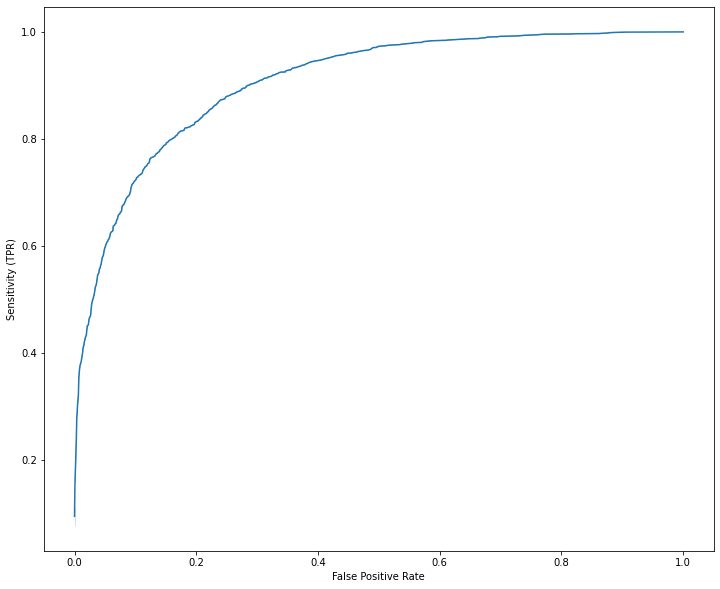

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for our model
fpr, tpr, thresh = roc_curve(y_test, predict_proba2(loaded_model,tokenized_test_inputs)[:, 1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.figure(figsize=(12,10))
sns.lineplot(x=fpr,y=tpr,);

plt.xlabel("False Positive Rate");
plt.ylabel("Sensitivity (TPR)");


In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(encoder, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
print(roc_auc_score(y_test, predict_proba2(loaded_model,tokenized_test_inputs)[:, 1]))


0.9062273714207801


In [ ]:
example="I am so happy to be working with you guys."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

I am so happy to be working with you guys.
[0]


In [ ]:
example="Silence is golden. Duct tape is silver."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Silence is golden. Duct tape is silver.
[1]


In [ ]:
example="It’s okay if you don’t like me. Not everyone has good taste."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

It’s okay if you don’t like me. Not everyone has good taste.
[1]


In [ ]:
example="Well at least your mom thinks you’re pretty ."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Well at least your mom thinks you’re pretty .
[1]


In [ ]:
example="Me pretending to listen should be enough for you."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Me pretending to listen should be enough for you.
[1]


In [ ]:
example="Marriage. Because your crappy day doesn’t have to end at work."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

Marriage. Because your crappy day doesn’t have to end at work.
[1]


In [ ]:
example="I am so happy to be 
working with you guys."
sentence=tokenizer.encode(preprocess(example))
sentence=tf.keras.preprocessing.sequence.pad_sequences([sentence],value=0,padding='post',maxlen=50)
print(example)
print(predict(loaded_model,sentence))

I am so happy to be working with you guys.
[0]
